# Test and debug Kalman filter

---

## Equations verified by the simulator

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}

## Equations employed by the Kalman filter

The Kalman state vector is:
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
\gamma_e \\
V_e \\
\end{array}\right)
\end{align*}
Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.


which dimensionally is equivalent to:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (\gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import cognac.float as fl

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
#print(w)

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-350.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='ENSTA')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-50.)

-3248.9 g  were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.80 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte = m/V = 1.02e+09 kg.cm^3   - float baseline density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 115.47 cm^3      - present volume addition
  lead  = 0.18 cm        - screw lead
  d_increment  = 0.00 m        - smallest variation 

In [4]:
# adjust piston to be at equilibrium 0m
iz = np.argmin(np.abs(z+0.))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

Piston reset for equilibrium : vol=-1.0e+01 cm^3  
z equilibrium = -1.0m


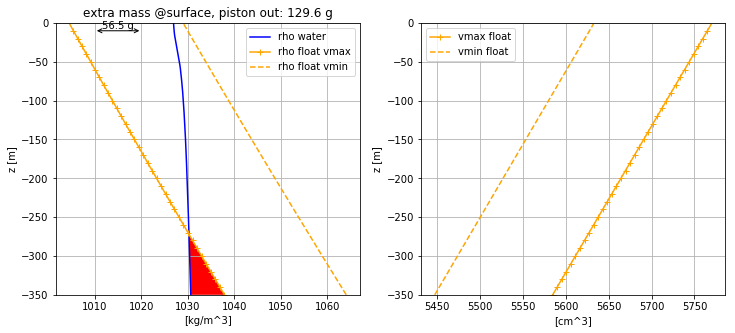

In [5]:
# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

In [6]:
delta_rho = 5 # change of water density over the depth of interest
L_rho = 100 # characteristic length scale for water density changes

### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:
\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}
where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$
and $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$.


V_e ~ 2.8e-05


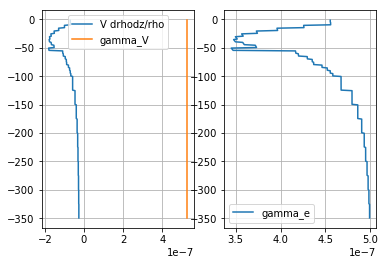

In [7]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()
ax.legend()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

print('V_e ~ %.1e' %(f.V*delta_rho/f.rho_cte))

---

## From the surface down to a target level

In [8]:
# we start by constructing a trajectory that can be followed by the float
z_target = fl.descent(3600, -25., f, w, zstart = 0)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.4e-01 m^2/s, wmax= 384.8 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.6e+03 cm/s


In [9]:
f0 = deepcopy(f)

### Kalman filter with exact dynamical system

The true dynamical equation is reset to that used by the Kalman and regulation:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [10]:
V_e = 1e-5
gamma_e = 0.5*f.gammaV

def _compute_force(z, w, waterp, Lv, v=None):
    g = 9.81
    _f = g * f.rho_cte * (V_e + gamma_e * z + v)
    _f += - f.m * f.c1/2/Lv * np.abs(w) * w
    return _f
f.compute_force = _compute_force

 ctrl: dt = 1.0
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 10.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: kalman = Kalman filter object: 
  dt     = 1.00 s     - filter time step
  x_hat   = [-0.00e+00,-0.00e+00,5.26e-07,0.00e+00] - kalman state 
[[1.60e-03 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e-04 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 2.77e-13 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 7.61e-10]]
 ctrl: mode = kalman_feedback
Start time stepping for 23 min ...
... time stepping done


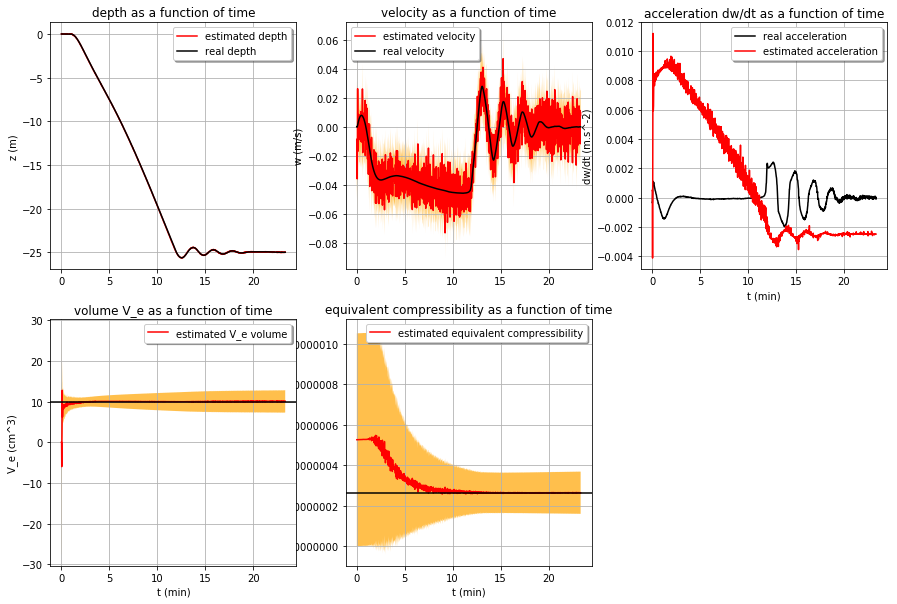

In [11]:
#control = {'mode': 'kalman_feedback', 'tau': 1., 'dz_nochattering': 0.01, 'nu': 0.04*(2/np.pi), 'delta': 0.15}
_c = {'mode': 'kalman_feedback', 'dt': 1., 'tau': 10., 'nu': 0.04*(2/np.pi), 'delta': 0.15, 'dz_nochattering': 0.}

_k = {'dt':1., 'depth_rms': 1e-2, 'velocity': _c['nu']*np.pi/2., 'acceleration': _c['nu']*np.pi/2./_c['tau']}
_k.update({'gamma':np.array([_k['velocity'],_k['depth_rms'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2})

# with identical physics
_k.update({'gamma_alpha': _k['gamma']*1e-5})
# 1e-0: regulation works but filter is off and diverging with large errors
# 1e-4: filter converges toward expected values with moderate uncertainties
# with real physics
#_k.update({'gamma_alpha_scaled': np.array([_k['acceleration'], _k['dt']**2*_k['acceleration'],
#                                           _k['velocity']*f.gammaV,
#                                           _k['velocity']*5.*f.V/f.rho_cte/100.,
#                                           ])**2 *1e-2})
# what is gamma_alpha/gamma

f.time_step(w,T=1400., dt_step=.1, dt_log=1., z=0., w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

fl.plot_kalman(f.log, f, V_e = V_e, gamma_e = gamma_e)

Extrapolated energy conssumption: 8.5e-04 Wh/day = 0.0 Wh/30day


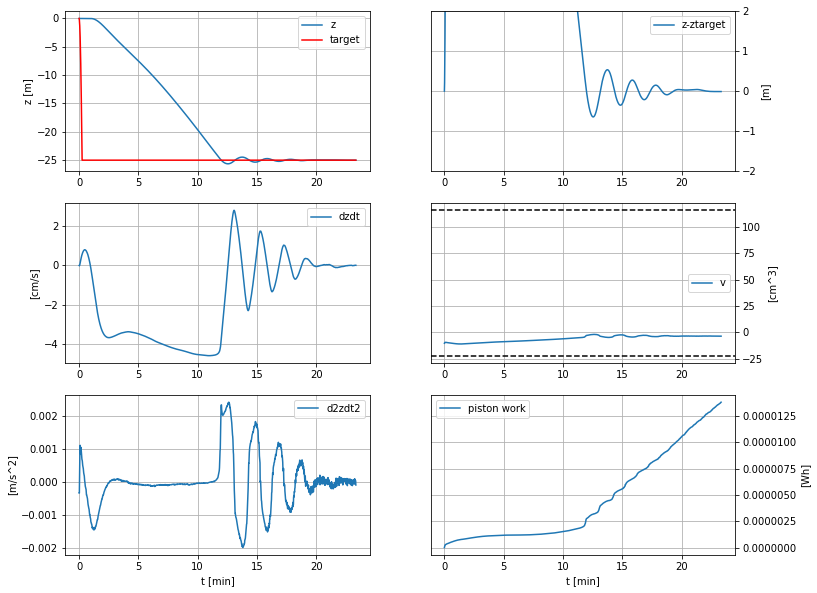

In [12]:
f.plot_logs(z_target=z_target)

### Kalman filter with approximate dynamical system

In [10]:
f = deepcopy(f0)

 ctrl: dt = 1.0
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 10.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: kalman = Kalman filter object: 
  dt     = 1.00 s     - filter time step
  x_hat   = [-0.00e+00,-0.00e+00,5.26e-07,0.00e+00] - kalman state 
[[1.60e-03 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e-04 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 2.77e-13 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 7.61e-10]]
 ctrl: mode = kalman_feedback
Start time stepping for 23 min ...
... time stepping done


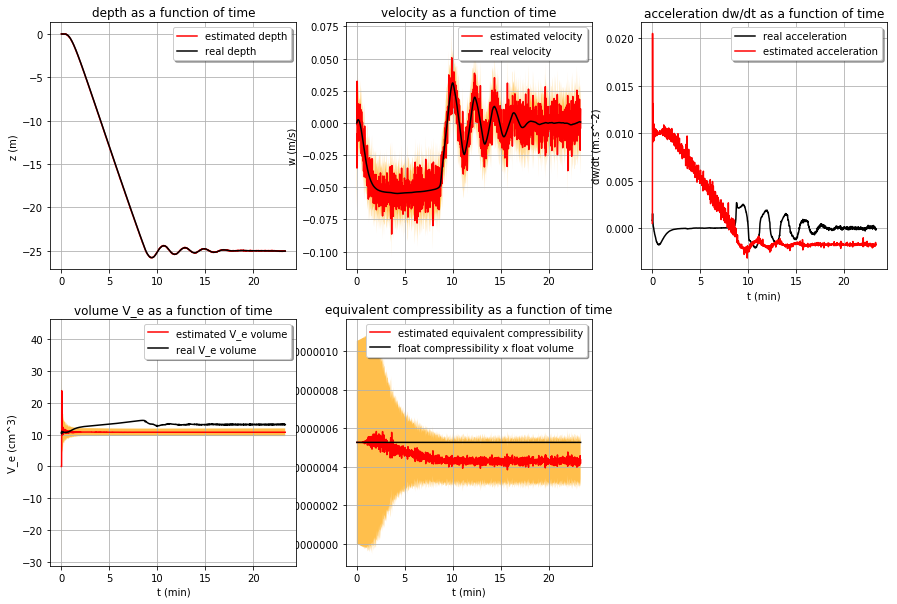

In [11]:
#control = {'mode': 'kalman_feedback', 'tau': 1., 'dz_nochattering': 0.01, 'nu': 0.04*(2/np.pi), 'delta': 0.15}
_c = {'mode': 'kalman_feedback', 'dt': 1., 'tau': 10., 'nu': 0.04*(2/np.pi), 'delta': 0.15, 'dz_nochattering': 0.}

_k = {'dt':1., 'depth_rms': 1e-2, 'velocity': _c['nu']*np.pi/2., 'acceleration': _c['nu']*np.pi/2./_c['tau']}
_k.update({'gamma':np.array([_k['velocity'],_k['depth_rms'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2})

# with real physics
_k.update({'gamma_alpha_scaled': np.array([_k['acceleration'], _k['dt']**2*_k['acceleration'],
                                           _k['velocity']*f.gammaV,
                                           _k['velocity']*f.V*delta_rho/f.rho_cte/L_rho,
                                           ])**2})
# what is gamma_alpha/gamma?

f.time_step(w,T=1400., dt_step=.1, dt_log=1., z=0., w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

fl.plot_kalman(f.log, f) #, V_e = V_e, gamma_e = gamma_e)

Extrapolated energy conssumption: 1.2e-03 Wh/day = 0.0 Wh/30day


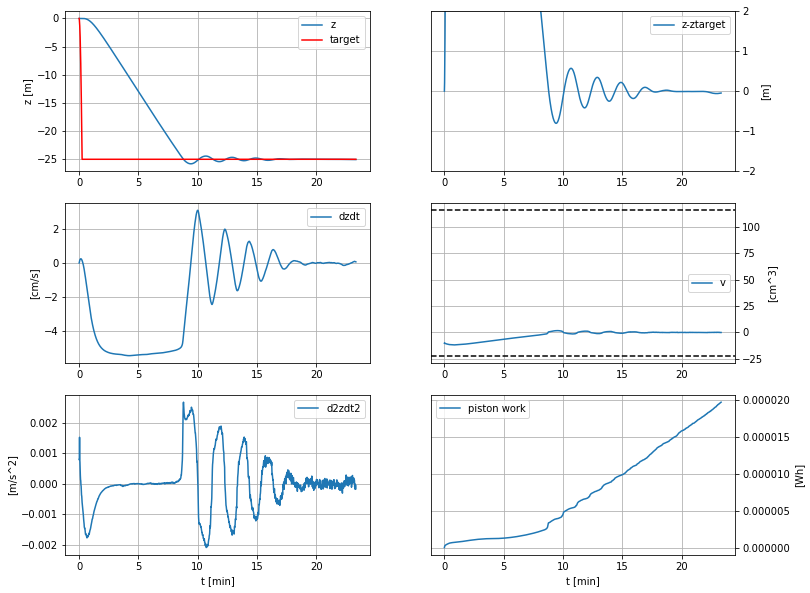

In [12]:
f.plot_logs(z_target=z_target)

In [12]:
#
dt = 1. #s
depth_rms = 1e-2 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-7
t2V = f.piston.vol_error  #vol_error = 7.e-08
gamma_alpha_gammaE = 1e-8
A_coeff = 9.81*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'vol_error': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': (dt**2)*np.diag([(A_coeff*Ve_rms)**2, (depth_rms)**2, (gamma_alpha_gammaE)**2, (Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])}
#
f.time_step(w,T=1400., dt_step=.1, dt_log=1., z=0., w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 23 min ...
... time stepping done


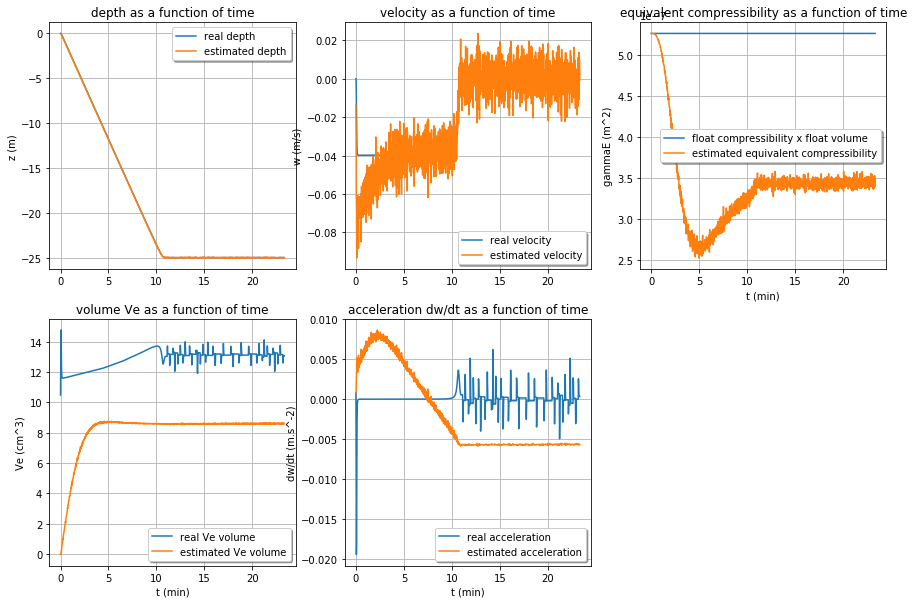

In [13]:
#f.plot_logs(z_target=z_target)
fl.plot_kalman(f.log, f)

---

## Oscillations around a fixed level

In [14]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/1200.*t)

In [15]:
f.time_step(w,T=1800., dt_step=.1, dt_log=1.,
            piston=True, z_target=z_target, ctrl=control, kalman=kalman)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 8.3e-04 Wh/day = 0.0 Wh/30day


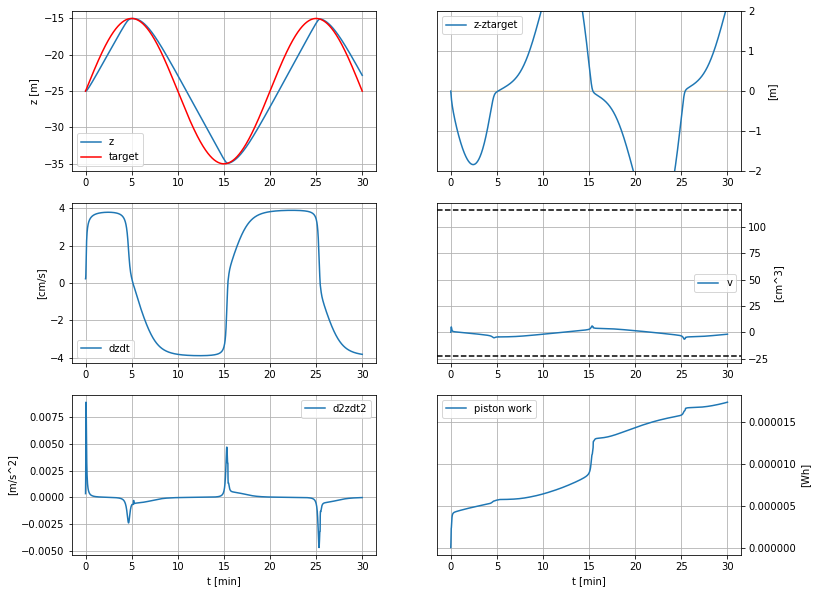

In [16]:
f.plot_logs(z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [17]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [18]:
f.time_step(w,T=1800., dt_step=.1, dt_log=1., piston=True, z_target=z_target, ctrl=control, kalman=kalman, eta=eta)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.01
 ctrl: tau = 1.0
 ctrl: nu = 0.025464790894703257
 ctrl: delta = 0.15
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.796134381066166
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 1.5e-02 Wh/day = 0.4 Wh/30day


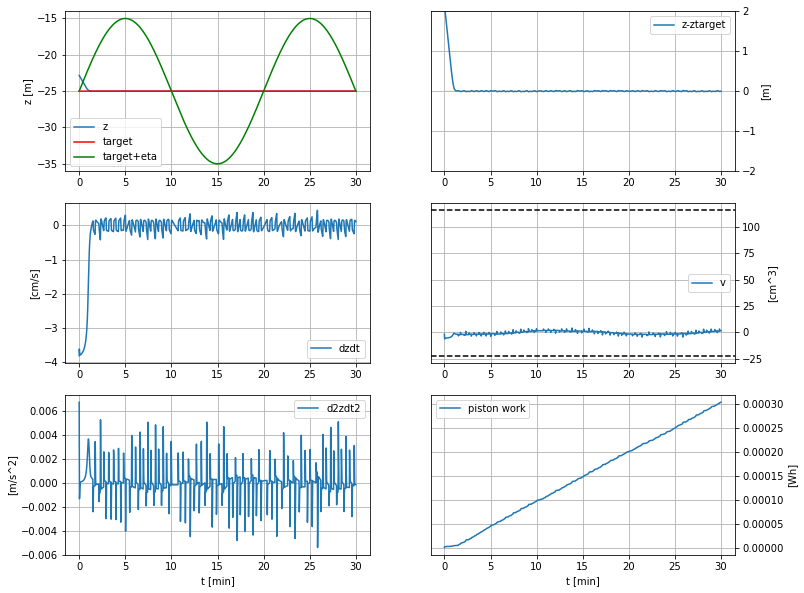

In [19]:
f.plot_logs(z_target=z_target, eta=eta)